# Exploratory Data Analysis on the **Titanic** Dataset  
_Report_

## 1. Introduction
**Dataset origin & scope:**  
The Titanic dataset contains information on 891 passengers aboard the RMS Titanic’s maiden voyage (1912). Each row represents a passenger with variables such as survival status, ticket class, sex, age, family relations aboard, fare, cabin number, and port of embarkation.

**Business / analytic goal:**  
Identify which factors were most associated with survival and test historical claims such as “women and children first” and whether upper‑class passengers received preference.

**Guiding questions:**
- What is the strongest factor in determining survival?
- Did upper‑class passengers get preference on lifeboats?
- Was “women and children first” truly applied?
- What additional pattern(s) emerge from the data?

In [1]:
import pandas as pd
import numpy as np

# For Box-Cox Transformation
from scipy import stats
# For standard scaling
# For min_max scaling
from mlxtend.preprocessing import minmax_scaling

# Plotting modules
import seaborn as sns
import missingno
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt


df = pd.read_csv('Titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2. Data Cleaning
**Initial checks:** `df.info()`, `df.describe()`, `missingno.matrix()`  
**Type fixes:**  
- `Pclass` → categorical  
- `Survived` → integer/binary  
- Encoded `Sex`, `Embarked`, etc. for analysis

**Feature engineering:**  
- `FamilySize = SibSp + Parch + 1`  
- `FamilySizeCapped = FamilySize (>=6 → '6+')`  
- `IsAlone = 1 if FamilySize == 1 else 0`  
- `Child = 1 if Age < 16 else 0`  
- `HasCabin = 1 if Cabin not null else 0`

In [2]:
# Display concise summary of the DataFrame, including column types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
# Convert columns to 'category' dtype for efficient storage and analysis
df['Pclass'] = df['Pclass'].astype('category')



In [4]:
# Display summary statistics for numerical columns in the DataFrame
df.describe()

,PassengerId,Survived,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,80.000000,8.000000,6.000000,512.329200


## 3. Missing Data
**Summary table (counts & %):**
| Variable | Missing | % Missing | Action |
|----------|---------|-----------|--------|
| Age | 177 | 19.87% | Impute median by (Sex, Pclass) |
| Cabin | 687 | 77.10% | Do not impute; use `HasCabin` flag |
| Embarked | 2 | <1% | Impute mode (‘S’) |



**Rationale:**  
- Preserve sample size without distorting distributions.  
- Convert sparse columns to informative flags instead of forcing guesses.

In [5]:
# columns with missing values and their percentage
missing_values_count = df.isnull().sum()
missing_percentage = (missing_values_count / len(df)) * 100
missing_info = pd.DataFrame({
    'Missing': missing_values_count[missing_values_count > 0],
    '% Missing': missing_percentage[missing_values_count > 0].round(2)
})
print("Fields with Missing Values:\n", missing_info)

Fields with Missing Values:
           Missing  % Missing
Age           177      19.87
Cabin         687      77.10
Embarked        2       0.22


<Axes: >

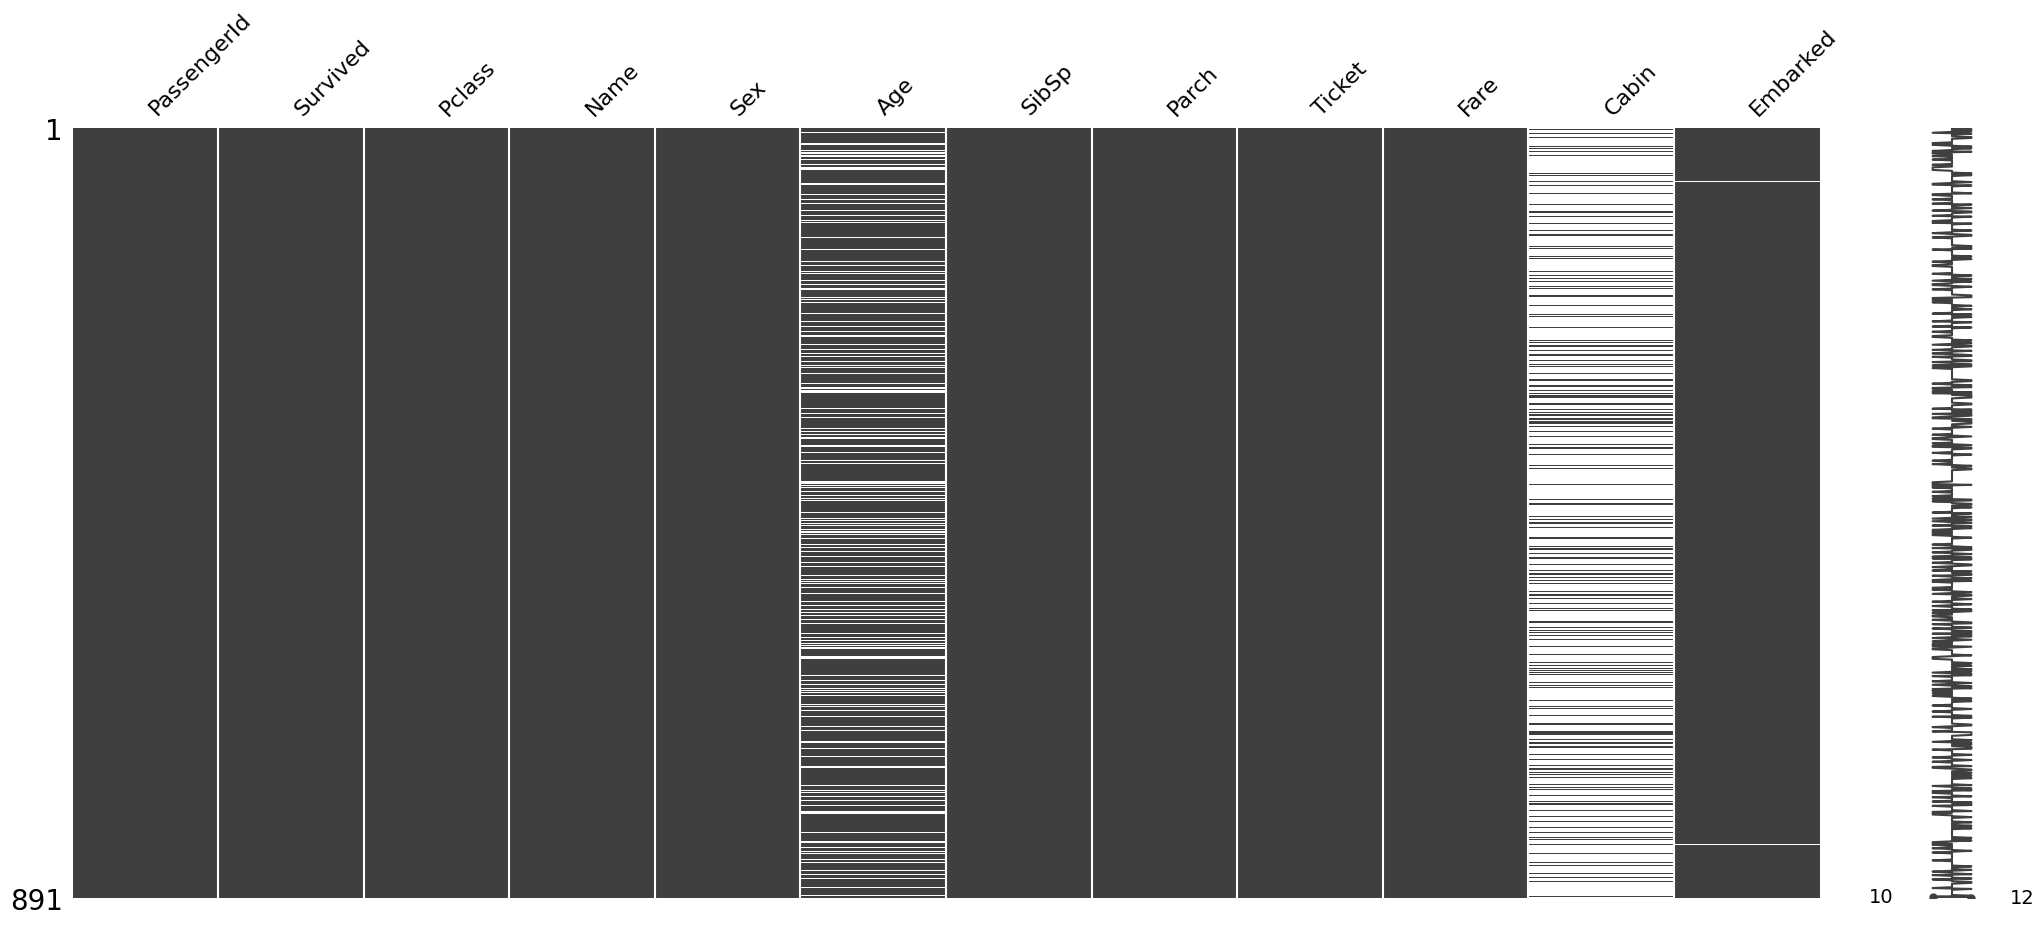

In [6]:
missingno.matrix(df)

In [7]:
# Impute Embarked (mode)
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
# Impute Age by Sex+Pclass median
df['Age'] = df.groupby(['Sex','Pclass'])['Age'].transform(
    lambda s: s.fillna(s.median())
)

C:\Users\lmkhungo\AppData\Local\Temp\ipykernel_36592\1122062749.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['Age'] = df.groupby(['Sex','Pclass'])['Age'].transform(


In [8]:

df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
df['HasCabin'] = df['Cabin'].notna().astype(int)
df['Child'] = ((df['Age'] < 16).astype(int))

In [9]:
mean_of_age = df.groupby('Survived')['Age'].mean()
print(f"Mean of Age by Survival: \n{mean_of_age}")

median_of_age = df.groupby('Survived')['Age'].median()
print(f"Median of Age by Survival: \n{median_of_age}")

Mean of Age by Survival: 
Survived
0    29.737705
1    28.108684
Name: Age, dtype: float64
Median of Age by Survival: 
Survived
0    25.0
1    27.0
Name: Age, dtype: float64


## 4. Data Stories & Visualisations


### 4.1 Upper‑class preference?
- 1st class survival ~60%, 2nd ~50%, 3rd ~30%.  
- Stacked bars showing class composition among survivors vs non-survivors.

C:\Users\lmkhungo\AppData\Local\Temp\ipykernel_29192\3810094400.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('Pclass')['Survived'].size()
C:\Users\lmkhungo\AppData\Local\Temp\ipykernel_29192\3810094400.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  f = sns.barplot(x='Pclass', y='Survived', data=df, palette='Set3')


Text(0.5, 1.0, 'Survival Rate by Pclass')

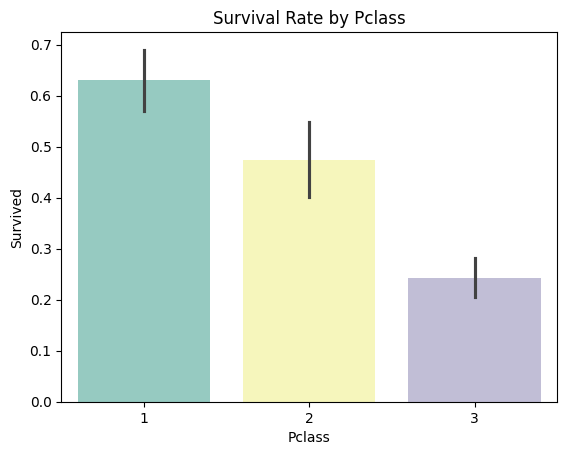

In [10]:
df.groupby('Pclass')['Survived'].size()
f = sns.barplot(x='Pclass', y='Survived', data=df, palette='Set3')
f.set_title('Survival Rate by Pclass')

- The bar plot above clearly shows that passengers in Pclass 1 had a significantly higher survival rate compared to those in Pclass 2 and Pclass 3


Text(0.5, 1.0, 'Survival Rate by Pclass & Gender')

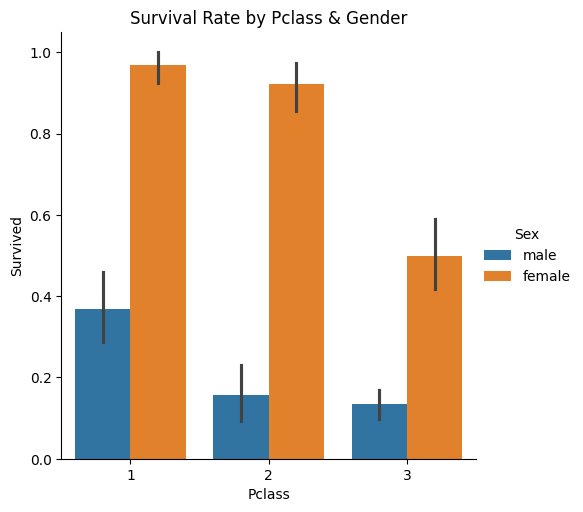

In [11]:
g = sns.catplot(x='Pclass', y='Survived', hue='Sex', kind='bar', data=df)
g.ax.set_title('Survival Rate by Pclass & Gender')

- Females in Pclass 1 & 2 has very high chance of Surviving than anyone.
- Males in Pclass 1 has higer chance of surviving than any males in other classes.
- Male Surviving rate is very low as compared to Female rate regardless of the class.
- **Conclusion:** Clear advantage for 1st class, supporting the “upper‑class preference” narrative.


### 4.2 “Women and children first”?
- Adult women: ~76% survival (highest group).  
- Female children: ~65%; male children: ~52%; adult men: ~17%.  
- Plot: `Survival Rate by Child & Sex`.

C:\Users\lmkhungo\AppData\Local\Temp\ipykernel_29192\2635164622.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sex', y='Survived', data=df, palette='Set2').set_title('Survival Rate by Gender')


Text(0.5, 1.0, 'Survival Rate by Gender')

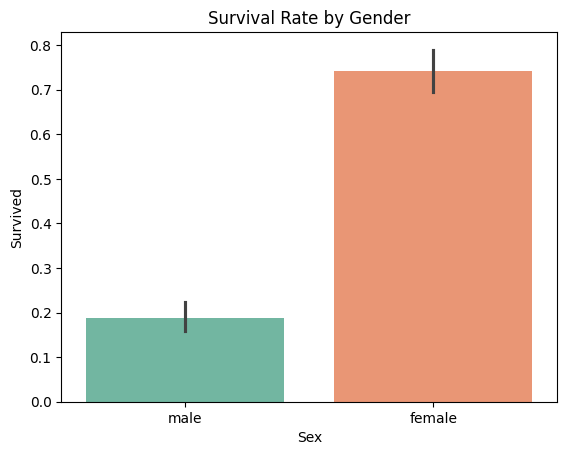

In [12]:
sns.barplot(x='Sex', y='Survived', data=df, palette='Set2').set_title('Survival Rate by Gender')


- There is a very high chance of female surviving with a rate more than 0.7 while Male has a rate less than 0.2

Text(0.5, 1.0, 'Survival Rate by Child & Adult')

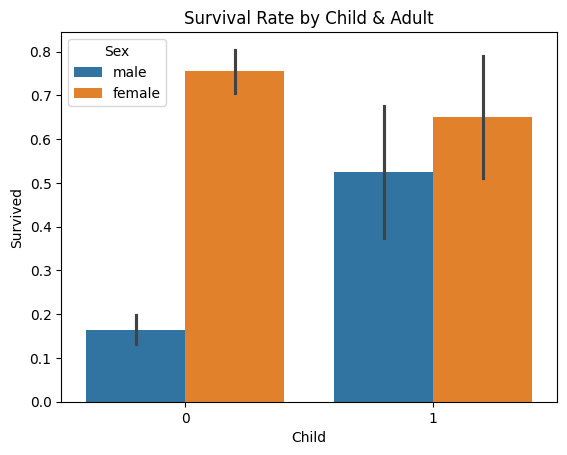

In [112]:
sns.barplot(x='Child', y='Survived', hue='Sex', data=df).set_title('Survival Rate by Child & Adult')

- Children were rescued before adult men.
- Women (particularly adult women) had the highest survival overall—even above female children.
- The plot confirms “women and children first,” but also reveals that adult women were at the very front of the line.
- **Conclusion:** Policy largely upheld; boys fared far better than adult men, but adult women were prioritised most.


### 4.3 Extra Insight: Family Size / IsAlone
- Moderate family size (2–4) boosts male survival from ~16% (alone) to ~40–50%.  
- Very large families (≥6) see a drop for both sexes.  
- Plot: `Survival Rate by FamilySizeCapped & Sex` and/or `IsAlone & Sex`.

Text(0.5, 1.0, 'Survival Rate by IsAlone & Not Alone')

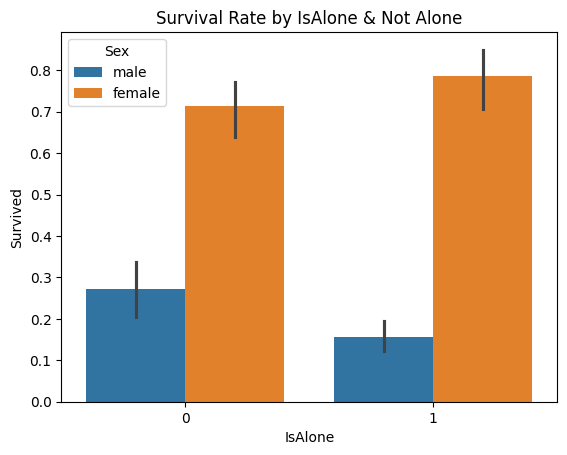

In [113]:
sns.barplot(x='IsAlone', y='Survived', hue='Sex', data=df).set_title('Survival Rate by IsAlone & Not Alone')

- Alone worsened male survival dramatically.
- Alone slightly boosted female survival.
- This mirror‑image effect underscores how both gender and social grouping shaped who got to safety first.

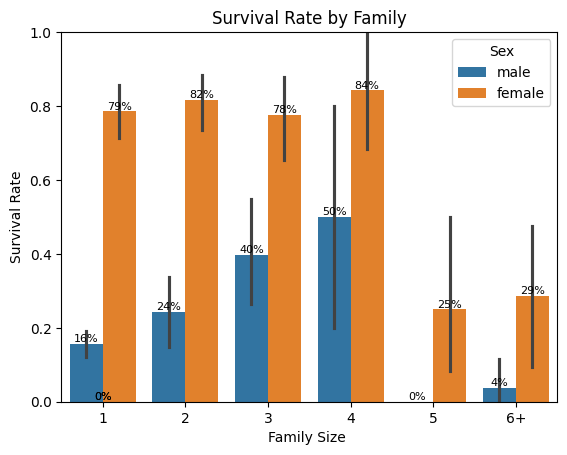

In [114]:
# Cap large families into a single bucket
df['FamilySizeCapped'] = df['FamilySize'].apply(lambda x: x if x <= 5 else '6+')

ax = sns.barplot(x='FamilySizeCapped', y='Survived', hue='Sex', data=df,
                 order=[1,2,3,4,5,'6+'])
ax.set_xlabel('Family Size ')
ax.set_ylabel('Survival Rate')
ax.set_title('Survival Rate by Family')
ax.set_ylim(0, 1)


# Annotate percentages
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.0%}",
                (p.get_x() + p.get_width()/2, height),
                ha='center', va='bottom', fontsize=8)


- Moderate family size was protective, especially for men (peaking at size 4).
- Women enjoyed high survival across nearly all family sizes—until the family became unwieldy.
- Very large families saw sharply lower survival for both sexes, suggesting that beyond a certain point, the logistics of keeping everyone together outweighed any benefit of having a support network.

### 4.4 What drives survival the most?
- **Correlation heatmap** (Pearson r on encoded variables) shows:
  - `Sex` (female=1): **r ≈ +0.54** (strongest)
  - `Pclass`: **r ≈ –0.34**
  - `Child`: **r ≈ +0.14** (much weaker)
- **Interpretation:** Gender dominates, followed by socio‑economic status (ticket class).

C:\Users\lmkhungo\AppData\Local\Temp\ipykernel_21756\2342342792.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({'6+': 6})


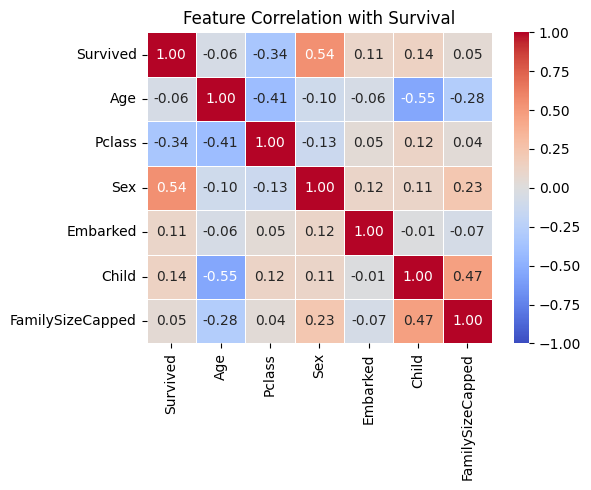

In [ ]:


# 1. Select & copy columns of interest 
cols = ['Survived', 'Age', 'Pclass', 'Sex', 'Embarked', 'Child', 'FamilySizeCapped']
df_corr = df[cols].copy()

# 2. Encode everything numerically
#    – Survived is already 0/1
df_corr['Survived'] = df_corr['Survived'].astype(int)
df_corr['Child'] = df_corr['Child'].astype(int)

#    – Sex {male:0, female:1}
df_corr['Sex'] = df_corr['Sex'].map({'male': 0, 'female': 1})

#    – Embarked  {S:0, C:1, Q:2}
df_corr['Embarked'] = df_corr['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

#    – FamilySizeCapped: replace '6+' with 6, then int
df_corr['FamilySizeCapped'] = (
    df_corr['FamilySizeCapped']
      .replace({'6+': 6})
      .astype(int)
)

#    – Pclass already numeric but ensure correct dtype
df_corr['Pclass'] = df_corr['Pclass'].astype(int)

# 3. Compute the Pearson correlation matrix
corr_mat = df_corr.corr()

# 4. Plot the heatmap
plt.figure(figsize=(6,5))
sns.heatmap(
    corr_mat,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    vmin=-1, vmax=1,
    linewidths=.5
)
plt.title('Feature Correlation with Survival')
plt.tight_layout()
plt.show()



- Gender remains the dominant signal (r≈0.54): females (coded 1) were far more likely to survive than males.
- Ticket class is next (r≈–0.34): lower class number (1st class) strongly boosts survival compared to 3rd class.
- Being a child (Age<16 coded as 1) has a modest positive association (r≈0.14), indicating that children did fare slightly better than adults overall, but the effect is much weaker than gender or class.
- Port of embarkation (r≈0.11) shows a small advantage for Cherbourg/Queenstown over Southampton.
- Family size (capped at 6+) and age have negligible linear relationships with survival when taken alone

## 5. Conclusions
- **Primary drivers:** Sex (female), then ticket class.  
- **Historical claims:** Data supports both “women first” and class preference. Children benefitted compared to adult men, but adult women topped survival odds.  
- **Additional finding:** Being in a small family group increased survival odds, especially for men; very large families struggled.

**Next steps / limitations:**  
- Pairwise correlations ignore confounding; a multivariate model (logistic regression, decision tree) could confirm independent effects.  
- Dataset represents only ~2/3 of passengers—missing data on crew and some passengers may bias results.  
- Socio‑economic status is proxied by class/fare; richer engineered features (deck, cabin location) could refine insight.

**This report was written by:** *Lungelo Mkhungo*  